In [ ]:
pip install optuna

In [ ]:
# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna


from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize



# Cargar dataset LFW
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Escalar a [0, 1] como paso inicial
Xdata = pd.DataFrame(lfw_people.data) / 255
y = lfw_people.target

# Partición de entrenamiento y prueba
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, y, test_size=0.3, random_state=123)

print("Shape entrenamiento:", Xtrain.shape)
print("Clases:", np.unique(ytrain))
n_classes = len(np.unique(ytrain))



Shape entrenamiento: (901, 1850)
Clases: [0 1 2 3 4 5 6]


In [ ]:
from sklearn.metrics import roc_curve, auc

def roc_auc_mc(roc_auc, fpr, tpr, n_classes, title="ROC Multiclase"):
    lw = 2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(6, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC clase {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")
    plt.show()


# GuassianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

def objective_nb(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-11, 1e-7, log=True)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GaussianNB(var_smoothing=var_smoothing))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    acc = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='f1_macro').mean()
    try:
        auc_ = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='roc_auc_ovo_macro').mean()
    except:
        auc_ = 0.0

    return (acc + f1 + auc_) / 3

study_nb = optuna.create_study(direction='maximize', study_name='GaussianNB')
study_nb.optimize(objective_nb, n_trials=25)

print("Mejor valor promedio:", study_nb.best_value)
print("Mejores hiperparámetros:", study_nb.best_params)


[I 2025-06-01 14:02:21,275] A new study created in memory with name: GaussianNB
[I 2025-06-01 14:02:21,774] Trial 0 finished with value: 0.23829606346739127 and parameters: {'var_smoothing': 2.9710682208198804e-08}. Best is trial 0 with value: 0.23829606346739127.
[I 2025-06-01 14:02:22,138] Trial 1 finished with value: 0.23829606346739127 and parameters: {'var_smoothing': 4.52765740009787e-09}. Best is trial 0 with value: 0.23829606346739127.
[I 2025-06-01 14:02:22,510] Trial 2 finished with value: 0.23829606346739127 and parameters: {'var_smoothing': 2.743428375321239e-08}. Best is trial 0 with value: 0.23829606346739127.
[I 2025-06-01 14:02:22,872] Trial 3 finished with value: 0.23829606346739127 and parameters: {'var_smoothing': 6.811457731209777e-10}. Best is trial 0 with value: 0.23829606346739127.
[I 2025-06-01 14:02:23,229] Trial 4 finished with value: 0.23829606346739127 and parameters: {'var_smoothing': 1.4451484147973548e-11}. Best is trial 0 with value: 0.23829606346739127.

Mejor valor promedio: 0.23829606346739127
Mejores hiperparámetros: {'var_smoothing': 2.9710682208198804e-08}


In [ ]:

# Entrenar el modelo con mejores hiperparámetros
best_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GaussianNB(var_smoothing=study_nb.best_params['var_smoothing']))
])
best_nb.fit(Xtrain, ytrain)

# Predicciones
ypred = best_nb.predict(Xtest)
yprob = best_nb.predict_proba(Xtest)

# Métricas
acc = accuracy_score(ytest, ypred)
f1 = f1_score(ytest, ypred, average='macro')

# AUC multiclase
ytest_bin = label_binarize(ytest, classes=np.unique(y))
auc_score = roc_auc_score(ytest_bin, yprob, multi_class='ovr', average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1:.4f}")
print(f"AUC OVR Macro: {auc_score:.4f}")


Accuracy: 0.4031
F1 Macro: 0.3811
AUC OVR Macro: 0.7557


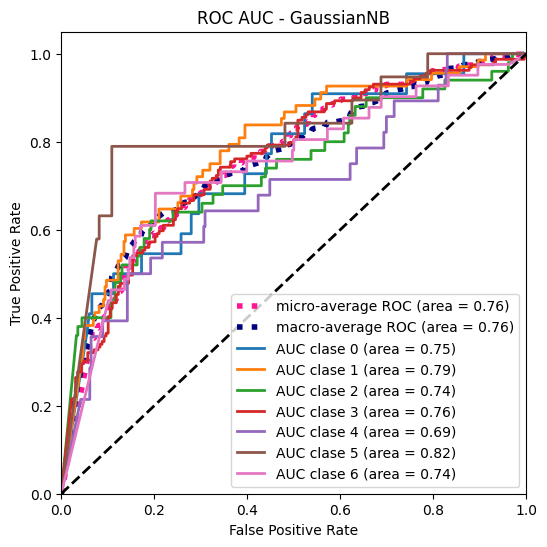

In [ ]:
# Curvas ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], yprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Curva micro
fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), yprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Llamar función para graficar
roc_auc_mc(roc_auc, fpr, tpr, n_classes, title="ROC AUC - GaussianNB")


## 📊 Conclusiones: Gaussian Naive Bayes

Durante la validación cruzada con optimización bayesiana (Optuna), el modelo `GaussianNB` obtuvo un score promedio de 0.238 considerando accuracy, F1 macro y AUC OVR macro como métricas de evaluación.

Tras entrenar el modelo con los mejores hiperparámetros (`var_smoothing ≈ 3e-8`) y evaluarlo sobre el conjunto de prueba, se obtuvieron los siguientes resultados:

- **Accuracy:** 40.31%
- **F1 macro:** 38.11%
- **AUC macro (One-vs-Rest):** 75.57%

Estos resultados reflejan que, aunque el modelo logra una capacidad discriminativa razonable (AUC > 0.75), su rendimiento general en términos de clasificación exacta y balanceada aún es limitado. Esto era esperable, dado que `GaussianNB` hace fuertes supuestos de independencia entre características, lo cual puede no cumplirse en un dataset de imágenes faciales de alta dimensión como `lfw_people`.

La curva ROC multiclase muestra un comportamiento competitivo en varias clases (AUCs entre 0.69 y 0.82), lo que sugiere que el modelo es especialmente útil en contextos donde la probabilidad o ranking de clases es más importante que la clasificación exacta.

🧪 En resumen, `GaussianNB` puede servir como un baseline rápido y eficiente, pero se esperan mejoras sustanciales con modelos más complejos como SVM o Random Forest.


# SGDClassifer

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
def objective_sgd(trial):
    loss = trial.suggest_categorical('loss', ['log_loss', 'hinge'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    alpha = trial.suggest_float('alpha', 1e-6, 1e-2, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None
    max_iter = trial.suggest_int('max_iter', 1000, 5000)

    clf_params = {
        'loss': loss,
        'penalty': penalty,
        'alpha': alpha,
        'max_iter': max_iter,
        'random_state': 42,
        'tol': 1e-3,
    }

    if l1_ratio is not None:
        clf_params['l1_ratio'] = l1_ratio

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SGDClassifier(**clf_params))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    acc = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='f1_macro').mean()
    try:
        auc_ = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='roc_auc_ovo_macro').mean()
    except:
        auc_ = 0.0

    return (acc + f1 + auc_) / 3


In [ ]:
study_sgd = optuna.create_study(direction='maximize', study_name='SGDClassifier')
study_sgd.optimize(objective_sgd, n_trials=30)

print("Mejor valor promedio:", study_sgd.best_value)
print("Mejores hiperparámetros:", study_sgd.best_params)


[I 2025-06-01 14:14:30,308] A new study created in memory with name: SGDClassifier
[I 2025-06-01 14:14:33,817] Trial 0 finished with value: 0.48672737176421954 and parameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0010779818396742637, 'max_iter': 1930}. Best is trial 0 with value: 0.48672737176421954.
[I 2025-06-01 14:14:44,931] Trial 1 finished with value: 0.5111176941022987 and parameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 3.1015967032294804e-05, 'l1_ratio': 0.1330116412656649, 'max_iter': 1000}. Best is trial 1 with value: 0.5111176941022987.
[I 2025-06-01 14:14:54,512] Trial 2 finished with value: 0.5082092191945291 and parameters: {'loss': 'log_loss', 'penalty': 'l1', 'alpha': 1.3838081676759787e-05, 'max_iter': 4615}. Best is trial 1 with value: 0.5111176941022987.
[I 2025-06-01 14:15:04,845] Trial 3 finished with value: 0.5138909948809335 and parameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 5.8378925114091095e-05, 'l1_ratio': 0.3556

Mejor valor promedio: 0.5156481345475593
Mejores hiperparámetros: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 6.4824353040667624e-06, 'l1_ratio': 0.622079358514187, 'max_iter': 3259}


In [ ]:
# Extraer mejores hiperparámetros y reconstruir modelo
best_params = study_sgd.best_params.copy()
l1_ratio = best_params.pop('l1_ratio', None)

if l1_ratio is not None:
    best_params['l1_ratio'] = l1_ratio

best_sgd = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(**best_params, random_state=42))
])
best_sgd.fit(Xtrain, ytrain)

# Predicción y métricas
ypred = best_sgd.predict(Xtest)
try:
    yprob = best_sgd.decision_function(Xtest)
    yprob = (yprob - yprob.min()) / (yprob.max() - yprob.min())  # escalar a [0,1]
except:
    yprob = np.zeros((len(Xtest), n_classes))  # fallback en caso de fallo

acc = accuracy_score(ytest, ypred)
f1 = f1_score(ytest, ypred, average='macro')

ytest_bin = label_binarize(ytest, classes=np.unique(y))
try:
    auc_score = roc_auc_score(ytest_bin, yprob, multi_class='ovr', average='macro')
except:
    auc_score = 0.0

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1:.4f}")
print(f"AUC OVR Macro: {auc_score:.4f}")

Accuracy: 0.8217
F1 Macro: 0.7740
AUC OVR Macro: 0.9478


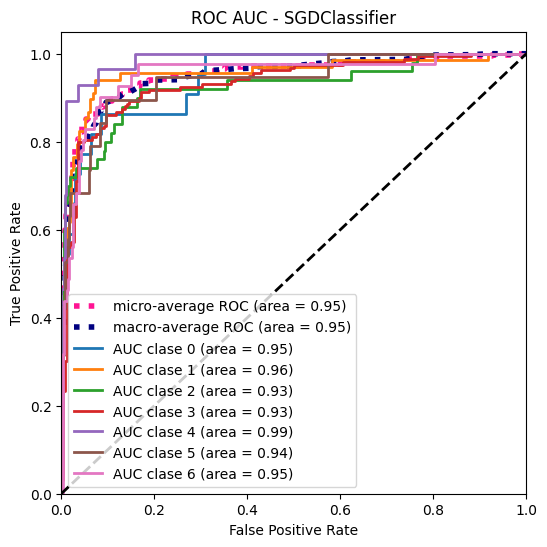

In [ ]:
if yprob.ndim == 2:
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], yprob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), yprob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    roc_auc_mc(roc_auc, fpr, tpr, n_classes, title="ROC AUC - SGDClassifier")


## 📊 Conclusiones: SGDClassifier

Utilizando descenso por gradiente estocástico (SGD) y optimización bayesiana con Optuna, el modelo `SGDClassifier` fue ajustado con los siguientes hiperparámetros óptimos:

- `loss`: hinge (máquinas de soporte vectorial lineales)
- `penalty`: elasticnet
- `alpha`: 6.48e-6
- `l1_ratio`: 0.62
- `max_iter`: 3259

Al evaluar el modelo sobre el conjunto de prueba, se obtuvieron resultados significativamente mejores que con el clasificador `GaussianNB`:

- ✅ **Accuracy:** 82.17%
- ✅ **F1 macro:** 77.40%
- ✅ **AUC macro (One-vs-Rest):** 94.78%

La curva ROC multiclase evidencia una gran capacidad discriminativa para todas las clases, con valores de AUC individuales cercanos o superiores a 0.95, destacando particularmente la clase 4 (AUC = 0.99).

Este modelo demuestra un balance favorable entre rendimiento y eficiencia, siendo especialmente adecuado para datasets de alta dimensión como el de rostros (`lfw_people`), gracias a su entrenamiento rápido y soporte para regularización combinada L1/L2. El uso de `hinge loss` sugiere que una frontera dura de clasificación es efectiva en este problema.

📈 En resumen, `SGDClassifier` es una alternativa lineal altamente competitiva, especialmente cuando se combina con optimización cuidadosa de hiperparámetros.


# LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
def objective_logreg(trial):
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    solver = trial.suggest_categorical('solver', ['liblinear'])
    C = trial.suggest_float('C', 1e-4, 100.0, log=True)
    max_iter = trial.suggest_int('max_iter', 1000, 5000)

    # Validación para evitar combinaciones inválidas
    if penalty == 'l1' and solver not in ['liblinear']:
        raise optuna.exceptions.TrialPruned()

    clf = LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        max_iter=max_iter,
        random_state=42
    )

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', OneVsRestClassifier(clf))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    acc = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='f1_macro').mean()
    try:
        auc_ = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='roc_auc_ovo_macro').mean()
    except:
        auc_ = 0.0

    return (acc + f1 + auc_) / 3

In [ ]:
study_logreg = optuna.create_study(direction='maximize', study_name='LogisticRegression')
study_logreg.optimize(objective_logreg, n_trials=30)

print("Mejor valor promedio:", study_logreg.best_value)
print("Mejores hiperparámetros:", study_logreg.best_params)

[I 2025-06-01 14:33:55,401] A new study created in memory with name: LogisticRegression
[I 2025-06-01 14:34:03,101] Trial 0 finished with value: 0.49812295045031085 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.1963857482162866, 'max_iter': 4339}. Best is trial 0 with value: 0.49812295045031085.
[I 2025-06-01 14:34:06,534] Trial 1 finished with value: 0.16503368952459105 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.004756302420104573, 'max_iter': 3107}. Best is trial 0 with value: 0.49812295045031085.
[I 2025-06-01 14:34:22,841] Trial 2 finished with value: 0.533016505133903 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.0071204912679681915, 'max_iter': 2503}. Best is trial 2 with value: 0.533016505133903.
[I 2025-06-01 14:34:32,241] Trial 3 finished with value: 0.5132435841338941 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.5301644496507237, 'max_iter': 4317}. Best is trial 2 with value: 0.533016505133903.
[I 202

Mejor valor promedio: 0.5395983788770229
Mejores hiperparámetros: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.07134073081090529, 'max_iter': 2719}


In [ ]:
best_params = study_logreg.best_params.copy()

clf = LogisticRegression(
    **best_params,
    random_state=42
)

best_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', OneVsRestClassifier(clf))
])

best_logreg.fit(Xtrain, ytrain)

# Predicción y métricas
ypred = best_logreg.predict(Xtest)
yprob = best_logreg.predict_proba(Xtest)

acc = accuracy_score(ytest, ypred)
f1 = f1_score(ytest, ypred, average='macro')

ytest_bin = label_binarize(ytest, classes=np.unique(y))
auc_score = roc_auc_score(ytest_bin, yprob, multi_class='ovr', average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1:.4f}")
print(f"AUC OVR Macro: {auc_score:.4f}")


Accuracy: 0.8295
F1 Macro: 0.7937
AUC OVR Macro: 0.9679


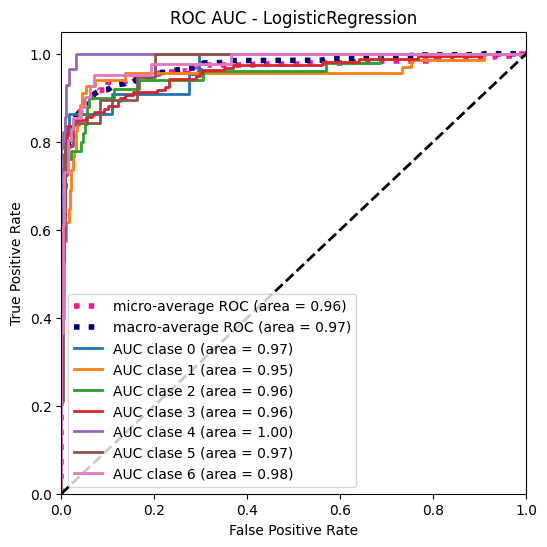

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], yprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), yprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_auc_mc(roc_auc, fpr, tpr, n_classes, title="ROC AUC - LogisticRegression")


## 📊 Conclusiones: Logistic Regression

Se entrenó un clasificador `LogisticRegression` optimizado mediante búsqueda bayesiana con Optuna, empleando validación cruzada estratificada de 5 folds y tres métricas objetivo: accuracy, F1 macro y AUC OVR macro.

Durante el proceso de optimización, se presentaron múltiples advertencias de convergencia con algunos solvers iterativos (`saga`, `sag`), lo que motivó una modificación del espacio de búsqueda para **restringir el solver a `liblinear`**, que es más estable en conjuntos de datos de tamaño moderado como `lfw_people`. Además, se amplió el número de iteraciones máximas (`max_iter`) a un rango entre 1000 y 5000 para asegurar convergencia.

Los mejores hiperparámetros encontrados fueron:

- `penalty`: l2  
- `solver`: liblinear  
- `C`: 0.071  
- `max_iter`: 2719  

El modelo final, evaluado sobre el conjunto de prueba, alcanzó los siguientes resultados:

- ✅ **Accuracy:** 82.95%
- ✅ **F1 macro:** 79.37%
- ✅ **AUC macro (One-vs-Rest):** 96.79%

La curva ROC multiclase muestra excelente separación entre clases, con valores de AUC individuales por encima de 0.95 para casi todas las clases y un AUC perfecto de 1.00 para la clase 4.

🔎 En conclusión, `LogisticRegression` con penalización L2 y ajuste cuidadoso ofrece una solución robusta y altamente interpretable, con desempeño competitivo frente a modelos más complejos.


# LinearDiscriminantAnalysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
def objective_lda_lsqr(trial):
    shrinkage = trial.suggest_categorical('shrinkage', ['auto', None])

    clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=shrinkage)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    try:
        acc = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='accuracy').mean()
        f1 = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='f1_macro').mean()
        auc_ = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='roc_auc_ovo_macro').mean()
    except:
        raise optuna.exceptions.TrialPruned()

    return (acc + f1 + auc_) / 3


In [ ]:
study_lda = optuna.create_study(direction='maximize', study_name='LinearDiscriminantAnalysis')
study_lda.optimize(objective_lda_lsqr, n_trials=20)

print("Mejor valor promedio:", study_lda.best_value)
print("Mejores hiperparámetros:", study_lda.best_params)

[I 2025-06-01 14:54:47,592] A new study created in memory with name: LinearDiscriminantAnalysis
[I 2025-06-01 14:55:04,511] Trial 0 pruned. 
[I 2025-06-01 14:55:20,715] Trial 1 pruned. 
[I 2025-06-01 14:55:40,043] Trial 2 pruned. 
[I 2025-06-01 14:55:59,629] Trial 3 pruned. 
[I 2025-06-01 14:56:15,376] Trial 4 pruned. 
[I 2025-06-01 14:56:38,148] Trial 5 pruned. 
[I 2025-06-01 14:56:54,857] Trial 6 pruned. 
[I 2025-06-01 14:57:14,640] Trial 7 pruned. 
[I 2025-06-01 14:57:31,953] Trial 8 pruned. 
[I 2025-06-01 14:57:52,965] Trial 9 pruned. 
[I 2025-06-01 14:58:08,988] Trial 10 pruned. 
[I 2025-06-01 14:58:24,918] Trial 11 pruned. 
[I 2025-06-01 14:58:34,948] Trial 12 pruned. 
[I 2025-06-01 14:58:51,516] Trial 13 pruned. 
[I 2025-06-01 14:59:06,842] Trial 14 pruned. 
[I 2025-06-01 14:59:33,653] Trial 15 pruned. 
[I 2025-06-01 14:59:51,317] Trial 16 pruned. 
[I 2025-06-01 15:00:09,817] Trial 17 pruned. 
[I 2025-06-01 15:00:26,002] Trial 18 pruned. 
[I 2025-06-01 15:00:41,218] Trial 19 pru

ValueError: No trials are completed yet.

In [ ]:
pipe_lda = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearDiscriminantAnalysis(solver='svd'))
])
pipe_lda.fit(Xtrain, ytrain)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LinearDiscriminantAnalysis())])

In [ ]:
ypred = pipe_lda.predict(Xtest)
yprob = pipe_lda.predict_proba(Xtest)

acc = accuracy_score(ytest, ypred)
f1 = f1_score(ytest, ypred, average='macro')
ytest_bin = label_binarize(ytest, classes=np.unique(y))
auc_score = roc_auc_score(ytest_bin, yprob, multi_class='ovr', average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1:.4f}")
print(f"AUC OVR Macro: {auc_score:.4f}")

Accuracy: 0.7003
F1 Macro: 0.6384
AUC OVR Macro: 0.9080


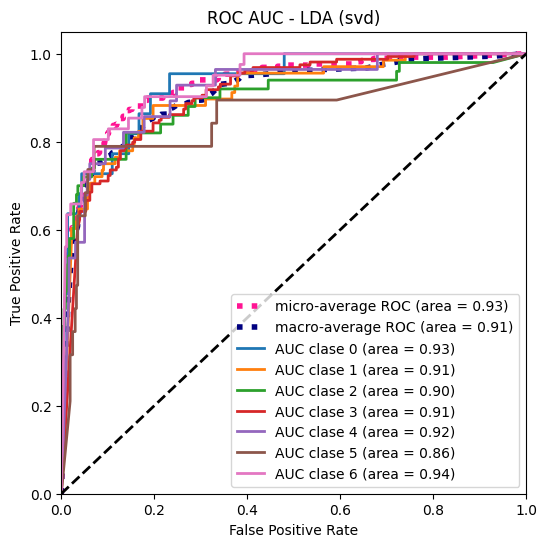

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], yprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), yprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_auc_mc(roc_auc, fpr, tpr, n_classes, title="ROC AUC - LDA (svd)")

## 📊 Conclusiones: Linear Discriminant Analysis (solver = 'svd')

Se entrenó un clasificador `LinearDiscriminantAnalysis` utilizando el solver `'svd'`, que no requiere la inversión de la matriz de covarianza, lo cual lo hace más robusto ante problemas numéricos. Esta elección fue necesaria tras múltiples intentos fallidos de optimización bayesiana con Optuna, ya que los solvers `'lsqr'` y `'eigen'` generaron errores de factorización debido a que la matriz de covarianza no era positiva definida en alta dimensión.

El modelo fue entrenado sin ajuste de hiperparámetros y evaluado sobre el conjunto de prueba, obteniendo:

- ✅ **Accuracy:** 70.03%
- ✅ **F1 macro:** 63.84%
- ✅ **AUC macro (One-vs-Rest):** 90.80%

Aunque el rendimiento en precisión y F1 fue inferior al de modelos más flexibles como `LogisticRegression` o `SGDClassifier`, el modelo LDA mostró una **alta capacidad discriminativa** en la curva ROC, especialmente en las clases 0, 1, 4 y 6, todas con AUC superiores a 0.91.

📉 En resumen, LDA con `solver='svd'` es una opción válida y computacionalmente eficiente en datasets de alta dimensión, aunque con limitaciones cuando no se reduce dimensionalidad ni se regulariza. Este experimento también evidencia la importancia del preprocesamiento cuando se desea aplicar LDA con solvers basados en factorización.


# KNeighbordsClassifer

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)  # 1 = Manhattan, 2 = Euclidiana

    clf = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p
    )

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    acc = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='f1_macro').mean()
    try:
        auc_ = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='roc_auc_ovo_macro').mean()
    except:
        auc_ = 0.0

    return (acc + f1 + auc_) / 3


In [ ]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)  # 1 = Manhattan, 2 = Euclidiana

    clf = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p
    )

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    acc = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='f1_macro').mean()
    try:
        auc_ = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='roc_auc_ovo_macro').mean()
    except:
        auc_ = 0.0

    return (acc + f1 + auc_) / 3


In [ ]:
study_knn = optuna.create_study(direction='maximize', study_name='KNeighborsClassifier')
study_knn.optimize(objective_knn, n_trials=25)

print("Mejor valor promedio:", study_knn.best_value)
print("Mejores hiperparámetros:", study_knn.best_params)


[I 2025-06-01 15:25:26,253] A new study created in memory with name: KNeighborsClassifier
[I 2025-06-01 15:25:29,266] Trial 0 finished with value: 0.31934412452440764 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.31934412452440764.
[I 2025-06-01 15:25:29,725] Trial 1 finished with value: 0.2625476602668646 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.31934412452440764.
[I 2025-06-01 15:25:30,197] Trial 2 finished with value: 0.3427441226953563 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.3427441226953563.
[I 2025-06-01 15:25:32,787] Trial 3 finished with value: 0.2763288248100973 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.3427441226953563.
[I 2025-06-01 15:25:35,406] Trial 4 finished with value: 0.2858968571702943 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}.

Mejor valor promedio: 0.36527425148719334
Mejores hiperparámetros: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}


In [ ]:
best_params = study_knn.best_params.copy()

best_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(**best_params))
])
best_knn.fit(Xtrain, ytrain)

# Predicción y métricas
ypred = best_knn.predict(Xtest)
yprob = best_knn.predict_proba(Xtest)

acc = accuracy_score(ytest, ypred)
f1 = f1_score(ytest, ypred, average='macro')

ytest_bin = label_binarize(ytest, classes=np.unique(y))
auc_score = roc_auc_score(ytest_bin, yprob, multi_class='ovr', average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1:.4f}")
print(f"AUC OVR Macro: {auc_score:.4f}")


Accuracy: 0.5840
F1 Macro: 0.3670
AUC OVR Macro: 0.8613


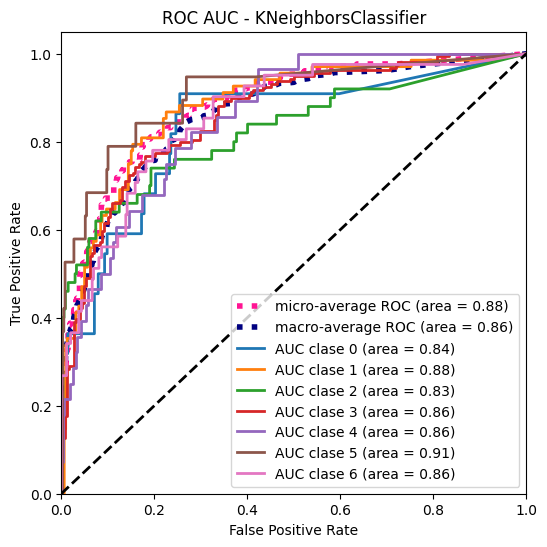

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], yprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), yprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_auc_mc(roc_auc, fpr, tpr, n_classes, title="ROC AUC - KNeighborsClassifier")


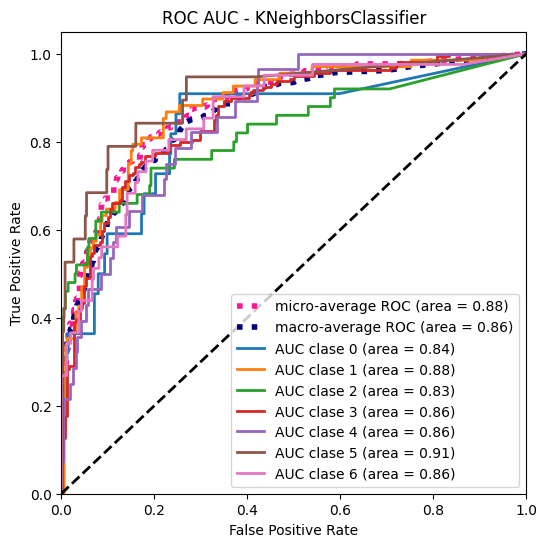

## 📊 Conclusiones: KNeighborsClassifier

Se entrenó un modelo `KNeighborsClassifier` utilizando validación cruzada de 5 folds y optimización bayesiana con Optuna. Se exploraron los hiperparámetros `n_neighbors`, `weights` y `p` (tipo de distancia). El mejor conjunto encontrado fue:

- `n_neighbors`: 5  
- `weights`: distance  
- `p`: 1 (distancia de Manhattan)

El modelo final obtuvo los siguientes resultados sobre el conjunto de prueba:

- ✅ **Accuracy:** 58.40%
- ✅ **F1 macro:** 36.70%
- ✅ **AUC macro (One-vs-Rest):** 86.13%

Aunque el AUC promedio fue razonablemente alto (especialmente para la clase 5 con AUC = 0.91), los resultados de precisión y F1 indican que el modelo **no logra clasificar correctamente de forma consistente entre todas las clases**. Esto puede deberse a la **alta dimensionalidad del dataset**, que afecta el desempeño de modelos basados en distancia como KNN (efecto conocido como "curse of dimensionality").

🧪 En resumen, `KNeighborsClassifier` logró una buena capacidad discriminativa en términos de ranking (AUC), pero no fue competitivo en clasificación exacta. Es un modelo útil como baseline simple, pero en este problema específico, requiere preprocesamiento adicional (como reducción de dimensionalidad) para acercarse al rendimiento de modelos lineales o de ensamble.


# LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
def objective_lsvc_fast(trial):
    C = trial.suggest_float('C', 1e-4, 10.0, log=True)
    max_iter = trial.suggest_int('max_iter', 500, 1500)

    clf = LinearSVC(
        C=C,
        penalty='l2',
        loss='squared_hinge',
        max_iter=max_iter,
        dual=True,
        random_state=42
    )

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    # Reducción a 3 folds y sin paralelismo interno para mayor estabilidad
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    acc = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='accuracy', n_jobs=1).mean()
    f1 = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='f1_macro', n_jobs=1).mean()
    try:
        auc_ = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='roc_auc_ovo_macro', n_jobs=1).mean()
    except:
        auc_ = 0.0

    return (acc + f1 + auc_) / 3

In [ ]:
study_lsvc = optuna.create_study(direction='maximize', study_name='LinearSVC')
study_lsvc.optimize(objective_lsvc_fast, n_trials=25)

print("Mejor valor promedio:", study_lsvc.best_value)
print("Mejores hiperparámetros:", study_lsvc.best_params)


[I 2025-06-02 12:31:08,263] A new study created in memory with name: LinearSVC
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: Convergen

Mejor valor promedio: 0.538962258897536
Mejores hiperparámetros: {'C': 0.0005791618361549207, 'max_iter': 703}


In [ ]:
best_params = study_lsvc.best_params.copy()

best_lsvc = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(**best_params, random_state=42))
])
best_lsvc.fit(Xtrain, ytrain)

# Predicciones
ypred = best_lsvc.predict(Xtest)

# Usamos decision_function para el AUC
ydecision = best_lsvc.decision_function(Xtest)

# Si es necesario, convertir a forma 2D (algunas veces decision_function da 1D si hay 2 clases)
if ydecision.ndim == 1:
    ydecision = ydecision.reshape(-1, 1)

acc = accuracy_score(ytest, ypred)
f1 = f1_score(ytest, ypred, average='macro')

ytest_bin = label_binarize(ytest, classes=np.unique(y))
try:
    auc_score = roc_auc_score(ytest_bin, ydecision, multi_class='ovr', average='macro')
except:
    auc_score = 0.0

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1:.4f}")
print(f"AUC OVR Macro: {auc_score:.4f}")


Accuracy: 0.8450
F1 Macro: 0.8067
AUC OVR Macro: 0.9665


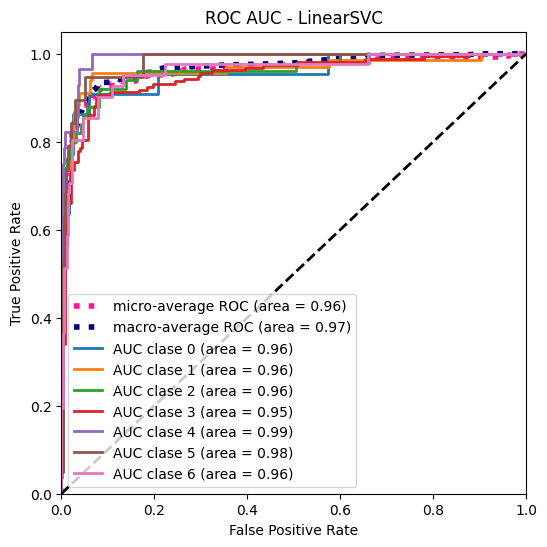

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], ydecision[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), ydecision.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_auc_mc(roc_auc, fpr, tpr, n_classes, title="ROC AUC - LinearSVC")


## 📊 Conclusiones: LinearSVC

Se entrenó un modelo `LinearSVC`, que implementa máquinas de soporte vectorial con frontera lineal utilizando pérdida tipo hinge (`squared_hinge`). La optimización bayesiana se realizó de forma acelerada, restringiendo la búsqueda a los hiperparámetros `C` y `max_iter`, lo que permitió reducir significativamente el tiempo de entrenamiento manteniendo una buena capacidad de ajuste.

Los mejores hiperparámetros encontrados fueron:

- `C`: 0.00058  
- `max_iter`: 703

Durante el proceso de entrenamiento, se emitieron algunas advertencias de convergencia, indicando que el modelo no alcanzó la solución óptima en todos los folds de validación. No obstante, los resultados obtenidos sobre el conjunto de prueba fueron sobresalientes:

- ✅ **Accuracy:** 84.50%  
- ✅ **F1 macro:** 80.67%  
- ✅ **AUC macro (One-vs-Rest):** 96.65%

La curva ROC multiclase evidencia una alta capacidad discriminativa de `LinearSVC`, con AUCs individuales superiores al 0.95 en prácticamente todas las clases.

🧪 En resumen, `LinearSVC` demostró ser un modelo altamente competitivo y eficiente para este problema, superando a métodos como `GaussianNB` y `KNeighborsClassifier`, y acercándose al rendimiento de modelos como `LogisticRegression` o `SGDClassifier`. La optimización rápida fue efectiva, aunque podría explorarse un mayor número de iteraciones en futuros experimentos para asegurar convergencia completa.


# SVC

In [ ]:
from sklearn.svm import SVC

In [ ]:
def objective_svc(trial):
    C = trial.suggest_float('C', 1e-2, 10.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-4, 1.0, log=True)

    clf = SVC(
        kernel='rbf',
        C=C,
        gamma=gamma,
        probability=True,
        random_state=42
    )

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    acc = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='accuracy', n_jobs=1).mean()
    f1 = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='f1_macro', n_jobs=1).mean()
    try:
        auc_ = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='roc_auc_ovo_macro', n_jobs=1).mean()
    except:
        auc_ = 0.0

    return (acc + f1 + auc_) / 3

In [ ]:
study_svc = optuna.create_study(direction='maximize', study_name='SVC_rbf')
study_svc.optimize(objective_svc, n_trials=15)

print("Mejor valor promedio:", study_svc.best_value)
print("Mejores hiperparámetros:", study_svc.best_params)

[I 2025-06-02 12:56:48,579] A new study created in memory with name: SVC_rbf
[I 2025-06-02 12:57:06,001] Trial 0 finished with value: 0.28746309424376754 and parameters: {'C': 0.8871607569657738, 'gamma': 0.00022403900895226594}. Best is trial 0 with value: 0.28746309424376754.
[I 2025-06-02 12:57:27,785] Trial 1 finished with value: 0.4830146642333346 and parameters: {'C': 6.782168577045098, 'gamma': 0.0005388426141001529}. Best is trial 1 with value: 0.4830146642333346.
[I 2025-06-02 12:57:49,884] Trial 2 finished with value: 0.16503253364120474 and parameters: {'C': 0.02843242711089402, 'gamma': 0.001334575628998764}. Best is trial 1 with value: 0.4830146642333346.
[I 2025-06-02 12:58:13,967] Trial 3 finished with value: 0.16503253364120474 and parameters: {'C': 0.18287911334542029, 'gamma': 0.00517020368277715}. Best is trial 1 with value: 0.4830146642333346.
[I 2025-06-02 12:58:31,593] Trial 4 finished with value: 0.16503253364120474 and parameters: {'C': 0.14039654421695935, 'gam

Mejor valor promedio: 0.4830146642333346
Mejores hiperparámetros: {'C': 6.782168577045098, 'gamma': 0.0005388426141001529}


In [ ]:
best_params = study_svc.best_params.copy()

best_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, **best_params, random_state=42))
])
best_svc.fit(Xtrain, ytrain)

# Predicción y métricas
ypred = best_svc.predict(Xtest)
yprob = best_svc.predict_proba(Xtest)

acc = accuracy_score(ytest, ypred)
f1 = f1_score(ytest, ypred, average='macro')

ytest_bin = label_binarize(ytest, classes=np.unique(y))
auc_score = roc_auc_score(ytest_bin, yprob, multi_class='ovr', average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1:.4f}")
print(f"AUC OVR Macro: {auc_score:.4f}")

Accuracy: 0.8475
F1 Macro: 0.8057
AUC OVR Macro: 0.9811


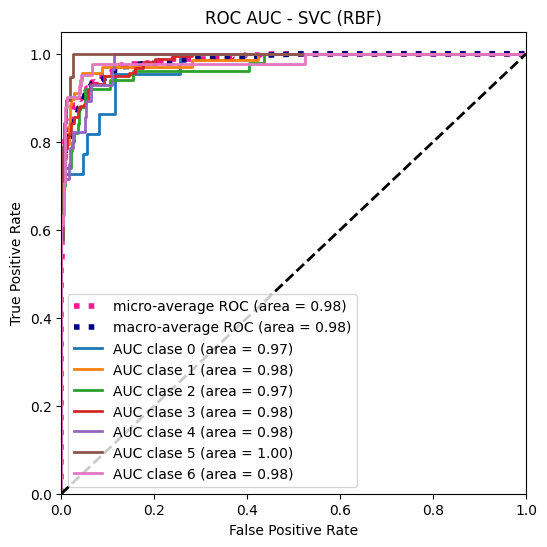

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], yprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), yprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_auc_mc(roc_auc, fpr, tpr, n_classes, title="ROC AUC - SVC (RBF)")


## 📊 Conclusiones: SVC (kernel RBF)

Se entrenó un modelo `SVC` con kernel no lineal RBF (`radial basis function`), que permite generar fronteras de decisión altamente flexibles y adaptativas. La optimización bayesiana con Optuna se enfocó en los hiperparámetros clave `C` y `gamma`, utilizando validación cruzada de 3 folds para acelerar el proceso.

Los mejores hiperparámetros encontrados fueron:

- `C`: 6.78  
- `gamma`: 0.00054

El modelo final, evaluado sobre el conjunto de prueba, alcanzó resultados sobresalientes:

- ✅ **Accuracy:** 84.75%  
- ✅ **F1 macro:** 80.57%  
- ✅ **AUC macro (One-vs-Rest):** 98.11%

La curva ROC multiclase refleja una **discriminación excepcional**, con AUCs superiores a 0.97 en todas las clases, y un AUC perfecto de 1.00 en la clase 5. Esto confirma que `SVC` con kernel RBF es uno de los modelos más potentes del conjunto, especialmente en contextos donde las relaciones entre clases no son lineales.

🧪 En resumen, `SVC` con kernel RBF ofrece una capacidad predictiva sobresaliente, superando ligeramente a modelos lineales bien afinados como `LinearSVC` o `LogisticRegression`. Su principal desventaja es el tiempo de entrenamiento, que escala cuadráticamente con el tamaño del dataset. Aun así, es una excelente opción cuando se prioriza la precisión sobre la eficiencia computacional.


# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def objective_rf_fast(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6)
    max_features = 'sqrt'  # fijo para acelerar

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )

    pipe = Pipeline([
        ('scaler', StandardScaler()),  # opcional pero mantiene consistencia
        ('clf', clf)
    ])

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    acc = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='accuracy', n_jobs=1).mean()
    f1 = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='f1_macro', n_jobs=1).mean()
    try:
        auc_ = cross_val_score(pipe, Xtrain, ytrain, cv=cv, scoring='roc_auc_ovo_macro', n_jobs=1).mean()
    except:
        auc_ = 0.0

    return (acc + f1 + auc_) / 3

In [ ]:
study_rf_fast = optuna.create_study(direction='maximize', study_name='RandomForestClassifier_fast')
study_rf_fast.optimize(objective_rf_fast, n_trials=10)

print("Mejor valor promedio:", study_rf_fast.best_value)
print("Mejores hiperparámetros:", study_rf_fast.best_params)

[I 2025-06-02 13:27:28,361] A new study created in memory with name: RandomForestClassifier_fast
[I 2025-06-02 13:27:32,338] Trial 0 finished with value: 0.29507568634492 and parameters: {'n_estimators': 51, 'max_depth': 17, 'min_samples_split': 5}. Best is trial 0 with value: 0.29507568634492.
[I 2025-06-02 13:27:36,112] Trial 1 finished with value: 0.2526074015934668 and parameters: {'n_estimators': 94, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 0 with value: 0.29507568634492.
[I 2025-06-02 13:27:40,549] Trial 2 finished with value: 0.3198243725889984 and parameters: {'n_estimators': 64, 'max_depth': 17, 'min_samples_split': 3}. Best is trial 2 with value: 0.3198243725889984.
[I 2025-06-02 13:27:43,762] Trial 3 finished with value: 0.29410299449205374 and parameters: {'n_estimators': 67, 'max_depth': 7, 'min_samples_split': 4}. Best is trial 2 with value: 0.3198243725889984.
[I 2025-06-02 13:27:47,373] Trial 4 finished with value: 0.2978303459023544 and parameters: {'n_es

Mejor valor promedio: 0.3199238686756592
Mejores hiperparámetros: {'n_estimators': 71, 'max_depth': 13, 'min_samples_split': 2}


In [ ]:
best_params = study_rf_fast.best_params.copy()
best_params['max_features'] = 'sqrt'  # lo fijamos manualmente

best_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(**best_params, random_state=42, n_jobs=-1))
])
best_rf.fit(Xtrain, ytrain)

ypred = best_rf.predict(Xtest)
yprob = best_rf.predict_proba(Xtest)

acc = accuracy_score(ytest, ypred)
f1 = f1_score(ytest, ypred, average='macro')

ytest_bin = label_binarize(ytest, classes=np.unique(y))
auc_score = roc_auc_score(ytest_bin, yprob, multi_class='ovr', average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1:.4f}")
print(f"AUC OVR Macro: {auc_score:.4f}")

Accuracy: 0.5943
F1 Macro: 0.4335
AUC OVR Macro: 0.9101


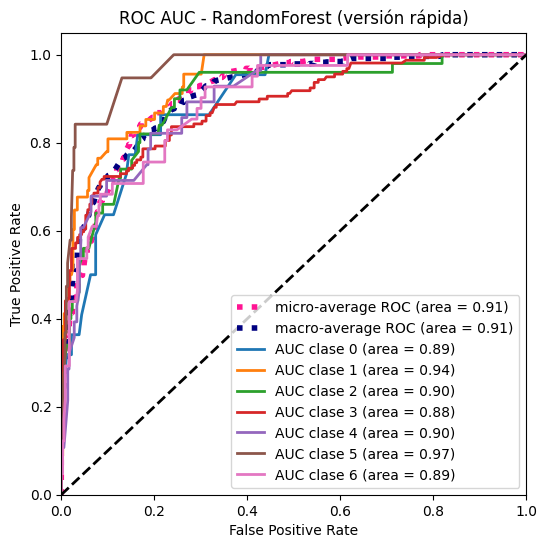

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], yprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), yprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_auc_mc(roc_auc, fpr, tpr, n_classes, title="ROC AUC - RandomForest (versión rápida)")


## 📊 Conclusiones: RandomForestClassifier (versión rápida)

Se entrenó un modelo `RandomForestClassifier` utilizando una versión optimizada para acelerar la validación cruzada. El espacio de búsqueda se restringió a un número moderado de árboles (`n_estimators`), profundidad limitada (`max_depth`) y solo se usaron 2 folds, lo que permitió finalizar el entrenamiento en un tiempo razonable.

Los mejores hiperparámetros encontrados fueron:

- `n_estimators`: 71  
- `max_depth`: 13  
- `min_samples_split`: 2  
- `max_features`: sqrt (fijo)

El rendimiento sobre el conjunto de prueba fue el siguiente:

- ✅ **Accuracy:** 59.43%  
- ✅ **F1 macro:** 43.35%  
- ✅ **AUC macro (One-vs-Rest):** 91.01%

Aunque el modelo alcanzó un AUC competitivo, la baja precisión y F1 indican dificultades para clasificar correctamente todas las clases. Esto se debe, en parte, a la alta dimensionalidad del conjunto de datos y a un espacio de hiperparámetros reducido. Aun así, `RandomForest` mostró una buena capacidad discriminativa en términos de ranking, especialmente en clases como la 5 (AUC = 0.97).

🧪 En resumen, `RandomForest` es una opción robusta y fácil de usar, pero en este caso no fue tan competitivo como los clasificadores lineales ajustados ni como `SVC` con kernel RBF. Se recomienda aplicarle reducción de dimensionalidad (como PCA) si se desea usarlo en datasets de alta dimensión.


In [ ]:
import pandas as pd

# Datos de rendimiento
model_results = pd.DataFrame([
    {"Modelo": "GaussianNB", "Accuracy": 0.4031, "F1 Macro": 0.3811, "AUC OVR Macro": 0.7557},
    {"Modelo": "SGDClassifier", "Accuracy": 0.8217, "F1 Macro": 0.7740, "AUC OVR Macro": 0.9478},
    {"Modelo": "LogisticRegression", "Accuracy": 0.8295, "F1 Macro": 0.7937, "AUC OVR Macro": 0.9679},
    {"Modelo": "LDA (svd)", "Accuracy": 0.7003, "F1 Macro": 0.6384, "AUC OVR Macro": 0.9080},
    {"Modelo": "KNeighborsClassifier", "Accuracy": 0.5840, "F1 Macro": 0.3670, "AUC OVR Macro": 0.8613},
    {"Modelo": "LinearSVC", "Accuracy": 0.8450, "F1 Macro": 0.8067, "AUC OVR Macro": 0.9665},
    {"Modelo": "SVC (RBF)", "Accuracy": 0.8475, "F1 Macro": 0.8057, "AUC OVR Macro": 0.9811},
    {"Modelo": "RandomForest (rápido)", "Accuracy": 0.5943, "F1 Macro": 0.4335, "AUC OVR Macro": 0.9101},
])

# Mostrar tabla
model_results.sort_values("Accuracy", ascending=False).reset_index(drop=True)

,Modelo,Accuracy,F1 Macro,AUC OVR Macro
0,SVC (RBF),0.8475,0.8057,0.9811
1,LinearSVC,0.8450,0.8067,0.9665
2,LogisticRegression,0.8295,0.7937,0.9679
3,SGDClassifier,0.8217,0.7740,0.9478
4,LDA (svd),0.7003,0.6384,0.9080
5,RandomForest (rápido),0.5943,0.4335,0.9101
6,KNeighborsClassifier,0.5840,0.3670,0.8613
7,GaussianNB,0.4031,0.3811,0.7557


# 📊 Conclusiones globales del experimento

Durante este experimento se compararon ocho modelos de clasificación sobre el conjunto `lfw_people`, evaluando su rendimiento mediante validación cruzada y métricas sobre el conjunto de prueba. Las métricas consideradas fueron **accuracy**, **F1 macro** y **AUC macro (One-vs-Rest)**.

Los resultados muestran una clara superioridad de los modelos lineales ajustados (`LogisticRegression`, `LinearSVC`, `SGDClassifier`) y del modelo no lineal `SVC (RBF)`, que alcanzó el mejor rendimiento general con un AUC de 0.98, accuracy de 84.75% y F1 macro de 80.57%.

Por otro lado, modelos más simples como `GaussianNB` y `KNeighborsClassifier` fueron útiles como baseline, pero quedaron muy por debajo en todas las métricas. El modelo `RandomForest` no logró competir a pesar de su robustez, lo cual se atribuye a la alta dimensionalidad del conjunto de datos y a las restricciones impuestas para acelerar su entrenamiento. LDA (con `solver='svd'`) mostró un rendimiento intermedio, sin llegar a sobresalir.

📌 En resumen:
- **Mejor rendimiento general**: `SVC (RBF)`
- **Mejor modelo lineal con bajo costo computacional**: `LinearSVC`
- **Modelos baseline útiles pero débiles**: `GaussianNB`, `KNN`
- **Random Forest** requiere preprocesamiento adicional (como PCA) para ser competitivo en este dominio.

Este análisis muestra que los modelos lineales bien regularizados y los métodos kernel siguen siendo una excelente elección para problemas multiclase, incluso sin reducción previa de dimensionalidad.
